In [19]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
from env import VanillaEnv
from policy import ActorNet
from common import plot_evaluation_grid, map_conf_to_index
import pandas as pd

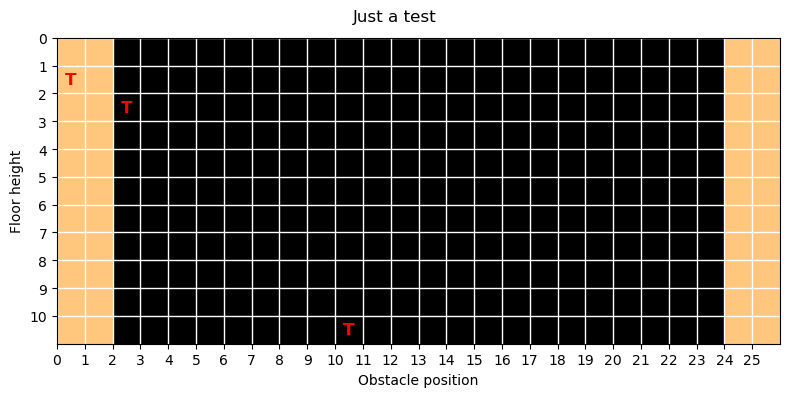

In [20]:
n_obstacle_pos = 26 # how many obstacle position you want to try out (paper: 27, max: 30)
n_floor_heights = 11 # how many floor heights you want to try out (paper: 11, max: 40)
obstacle_pos = np.rint(np.linspace(20, 45, n_obstacle_pos)).astype(np.int8)
floor_height = np.rint(np.linspace(10, 20, n_floor_heights)).astype(np.int8)

grid = np.zeros((len(obstacle_pos), len(floor_height)))

grid[1] = np.ones(11)
grid[0] = np.ones(11)
grid[-1] = np.ones(11)
grid[-2] = np.ones(11)

fig = plot_evaluation_grid(grid, [(0, 1), [2,2], [10,10]])
fig.suptitle("Just a test")
plt.show()


Loading model  train_bc-10.pth
Loading model  train_bc-20.pth
Loading model  train_bc-30.pth


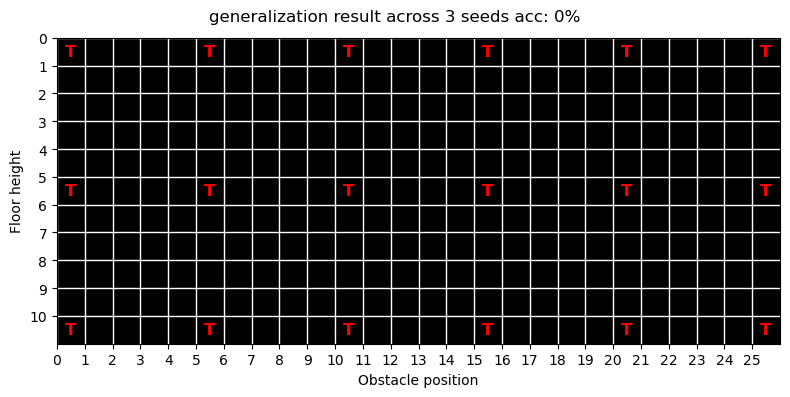

In [23]:
render = False
folder_name: str = './experiments/230721-212414/'

def play_episode(model: ActorNet, env: VanillaEnv)->bool:
    """
    returns true of the episode is concidered solved
    """
    model.eval()
    done = False
    episode_return = 0
    obs = env.reset()
    while not done:
        action_logits = model.forward(torch.FloatTensor(obs).unsqueeze(0), contrastive=False)
        action = torch.argmax(action_logits)
        obs, rewards, done, info = env.step(action.item())
        episode_return += rewards
        if render: env.render()
    return not info['collision']

models_names = [n for n in os.listdir(folder_name) if n.endswith('.pth')]

grid = np.zeros((len(obstacle_pos), len(floor_height)))
solved_counter, failed_counter = 0,0

for models_name in models_names:
    img_name = models_name.replace('.pth', '-eval.png')
    
    print("Loading model ", models_name)

    for obs_pos_idx in range(len(obstacle_pos)):
        for floor_height_idx in range(len(floor_height)):
            curr_obs_pos = obstacle_pos[obs_pos_idx]
            curr_floor_height = floor_height[floor_height_idx]

            # todo load the model and check performance for all configurations
            env = VanillaEnv([(curr_obs_pos, curr_floor_height),], rendering=render)

            model = ActorNet()
            ckp = torch.load(folder_name + models_name)
            model.load_state_dict(ckp['state_dict'])
            train_info = ckp['info']


            
            is_solved = play_episode(model, env)
            
            if is_solved: 
                grid[obs_pos_idx][floor_height_idx] += 1/len(models_names)
                solved_counter += 1
            else:
                failed_counter += 1

acc = round(solved_counter * 100 / (solved_counter + failed_counter))
fig = plot_evaluation_grid(np.fliplr(grid), map_conf_to_index(obstacle_pos, floor_height, train_info['conf']))
fig.suptitle(f"generalization result across {len(models_names)} seeds acc: {acc}%")
plt.savefig(folder_name + 'generalization.png')
plt.show()

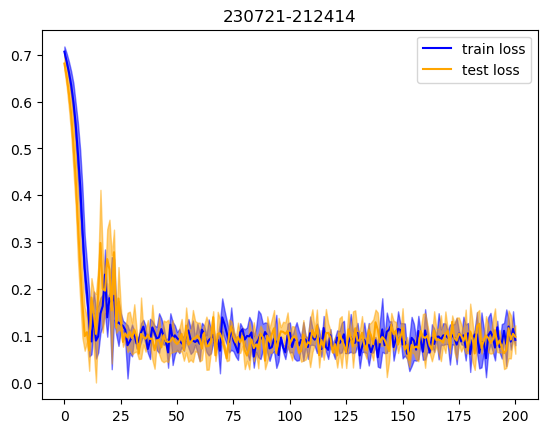

In [26]:
# folder_name: str = './experiments/230721-212414/'
log_names = [n for n in os.listdir(folder_name) if n.endswith('.csv')]
train_seqences, test_sequences = [], []

for log_name in log_names:
    df = pd.read_csv(folder_name + log_name)
    train_seqences.append(df['Train loss'])
    test_sequences.append(df['Test loss'])

train_df = pd.concat(train_seqences, axis=1)
test_df = pd.concat(test_sequences, axis=1)

x = train_df.index
y1 = train_df.mean(axis=1)
y2 = test_df.mean(axis=1)

y1_min = train_df.min(axis=1)
y1_max = train_df.max(axis=1)

y2_min = test_df.min(axis=1)
y2_max = test_df.max(axis=1)


plt.plot(x, y1, 'blue', label='train loss')
plt.plot(x, y2, 'orange', label='test loss')
plt.fill_between(x, y1_min, y1_max, color='blue', alpha=0.5)
plt.fill_between(x, y2_min, y2_max, color='orange', alpha=0.5)
plt.legend()
plt.title(folder_name.split('/')[-2])
plt.savefig(folder_name + 'loss.png')
plt.show()